## Build Features and Labels
1. Add problem instances (files with extension `.tsp`) into `tsplib-data/problems/` from one of these sources:
	1. To get it from TSPLIB, download a problem instance (file with extension `.tsp.gz`) from [TSPLIB95's symmetric TSP list](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/). Then extract the `.tsp` file.
	2. Copy one from `tsplib-data/problems-special/`.
2. If you want to build labels as well, and you want to use precomputed solutions to skip solving time, add solutions (files with extension `.opt.tour`) into `tsplib-data/solutions` from one of these sources:
	1. Similarly, you can download one from the same source as above. Some of the tour files have all the indices in the `TOUR_SECTION` on the same line, which may cause an error. To fix this, place each index on a new line.
	2. Copy one from `tsplib-data/solutions-special/`.
3. Choose desired features from the [features list](../README.md#Features).

**Config**

List the **short names** of each edge feature you want to extract in `DESIRED_EDGE_FEATURES` in `common.py`.

In [1]:
from common import *
build_directories_if_needed()

# Uses fg weights of 1/iteration (1-indexed) instead of iteration/k
USE_PAPER_FG = True

# Even if the features already exist, overwrite them
OVERRIDE_FEATURES = True

# Builds the ground truth labels directory (tsplib-data/npy/solutions/) along with the features directories
BUILD_LABELS = True

# Choose the layout function for arranging nodes in the visualizations
# Recommended choices: nx.spiral_layout, nx.spring_layout
import networkx as nx
DEFAULT_VIZ_LAYOUT = nx.spiral_layout

# Maximum number of problems to visualize (we recommend setting this low to avoid cluttering the notebook)
MAX_VISUALIZATIONS = 1

Building data directories...
Directory already exists: /Users/dtong/dev/TSPPruning/tsplib-data/problems
Directory already exists: /Users/dtong/dev/TSPPruning/tsplib-data/solutions
Created directory: /Users/dtong/dev/TSPPruning/tsplib-data/training


Imports and Utility functions

In [2]:
from optlearn.data.data_utils import dataLoader
loader = dataLoader([])

import numpy as np
np.set_printoptions(linewidth=np.inf)

Clear output directory to recompute all features and labels from scratch (optional)

In [3]:
clear_directory(TRAINING_PATH)

Cleared


Plotting utilities (required for plots)

In [4]:
from optlearn.graph_utils import get_edges, get_weights
from optlearn.io_utils import optObject

import matplotlib.pyplot as plt

from optlearn.plotting import get_x_y_lists

PYPLOT_W, PYPLOT_H = 4, 4 # in inches
ARC_RADIUS = 0.15

class TSPPlotData:
	def __init__(self, problem: optObject, problem_name: str):
		G = problem.get_graph()
		self.G = G
		self.edges = get_edges(G)
		coords = problem.get_keyword_dict()['NODE_COORD_SECTION']
		self.has_real_coords = coords != None
		self.pos = coords or DEFAULT_VIZ_LAYOUT(G)
		self.weights = get_weights(G)
		self.problem_name = problem_name
	
	def plot(self, edge_values_list, ax=None, use_alpha=False):
		nx.draw_networkx_nodes(self.G, self.pos, ax=ax)
		nx.draw_networkx_labels(self.G, self.pos, font_size=10, font_color='w', ax=ax)
		connectionstyle = 'arc3' + (f',rad={ARC_RADIUS}' if self.G.is_directed() else '')
		nx.draw_networkx_edges(
			self.G,
			self.pos,
			edge_color=('black' if use_alpha else 'grey'),
			ax=ax,
			alpha=(edge_values_list.clip(0, 1) if use_alpha else 1),
			connectionstyle=connectionstyle
		)
		if not use_alpha:
			edge_labels = {}
			for edge_idx, edge in enumerate(self.edges):
				edge_labels[edge] = round(edge_values_list[edge_idx], 3)
			nx.draw_networkx_edge_labels(
				self.G,
				self.pos,
				edge_labels,
				label_pos=(0.3 if self.G.is_directed() else 0.5),
				bbox={"alpha": 0},
				ax=ax,
				connectionstyle=connectionstyle
			)
	
	def __str__(self):
		coord_description = ('Cartesian' if self.has_real_coords else 'arbitrary') + ' coordinates'
		return f'({self.problem_name}, {coord_description})'

plot_cache: dict[str, TSPPlotData] = {}

Load Problems (required for pretty-printing/plots)

In [6]:
num_problems_loaded = 0
for problem_file_name in os.listdir(PROBLEMS_PATH):
	problem_name = problem_file_name.removesuffix('.tsp')
	problem_file_path = os.path.join(PROBLEMS_PATH, problem_file_name)
	# Returns graph with N(N - 1) edges (all directed edges besides loops)
	problem = optObject().read_problem_from_file(problem_file_path)
	plot_cache[problem_name] = TSPPlotData(problem, problem_name)
	num_problems_loaded += 1
print(f'Loaded {num_problems_loaded} problems')

Loaded 1000 problems


Plot problems (optional)

In [17]:
if len(plot_cache) > MAX_VISUALIZATIONS:
	print('Aborting visualization: too many problems')
else:
	for problem_name, plot_data in plot_cache.items():
		plot_data.plot(plot_data.weights)
		plt.title(f'Weights\n{plot_data}')
		plt.rcParams["figure.figsize"] = (PYPLOT_W, PYPLOT_H)
		plt.show()

Aborting visualization: too many problems


Build features (and labels if enabled)

In [7]:
import optlearn.mst.mst_model
optlearn.mst.mst_model.use_paper_fg = USE_PAPER_FG

import optlearn.data.data_utils
optlearn.data.data_utils.build_labels = BUILD_LABELS

import numpy as np
np.set_printoptions(linewidth=np.inf)

from optlearn.experiments.build_data import build_features
proceed = True
if OVERRIDE_FEATURES:
	if input('Proceed to build features and labels? This will overwrite any redundant directories. (y/n) ').lower() != 'y':
		print('Aborted')
if proceed:
	build_features(
		TRAINING_PATH,
		PROBLEMS_PATH,
		DESIRED_EDGE_FEATURES,
		override=OVERRIDE_FEATURES,
		solution_dir=SOLUTIONS_PATH
	)


Status:
Directory Status: Checked/Built




KeyError: 'compute_feature_dirs_edges'

Load features (required for pretty-printing/plotting)

In [ ]:
if len(plot_cache) > MAX_VISUALIZATIONS:
	print('Aborting visualization: too many problems')
else:
	for problem_name, plot_data in plot_cache.items():
		plot_data.features_data = loader.load_features([
			os.path.join(TRAINING_PATH, feature, problem_name + '.npy')
			for feature in DESIRED_EDGE_FEATURES])

Aborting visualization: too many problems


Pretty-print features in a table (optional)

In [20]:
from tabulate import tabulate
if len(plot_cache) > MAX_VISUALIZATIONS:
	print('Aborting visualization: too many problems')
else:
	for problem_name, plot_data in plot_cache.items():
		print(f'{problem_name}:')
		print(tabulate(
			plot_data.features_data,
			headers=DESIRED_EDGE_FEATURES,
			showindex=enumerate(plot_data.edges)
		))

Aborting visualization: too many problems


Plot features (optional)

In [21]:
if len(plot_cache) > MAX_VISUALIZATIONS:
	print('Aborting visualization: too many problems')
else:
	for problem_name, plot_data in plot_cache.items():
		# Based on
		# https://networkx.org/documentation/latest/auto_examples/drawing/plot_multigraphs.html#sphx-glr-auto-examples-drawing-plot-multigraphs-py
		fig, ax = plt.subplots(len(DESIRED_EDGE_FEATURES), 2)
		# Standardizes ax as a 2D list
		if len(DESIRED_EDGE_FEATURES) == 1:
			ax = [ax]

		for feature_idx, feature in enumerate(DESIRED_EDGE_FEATURES):
			ax_numeric: plt.Axes = ax[feature_idx][0]
			feature_data = plot_data.features_data[:,feature_idx]
			plot_data.plot(feature_data, ax=ax_numeric)
			ax_numeric.set_title(f'{feature} numeric\n{plot_data}')

			ax_alpha: plt.Axes = ax[feature_idx][1]
			plot_data.plot(feature_data, ax=ax_alpha, use_alpha=True)
			ax_alpha.set_title(f'{feature} alpha\n{plot_data}')
		
		fig.set_size_inches(PYPLOT_W * 2, PYPLOT_H * len(DESIRED_EDGE_FEATURES))
		plt.show()


Aborting visualization: too many problems


Load and plot computed optimal solutions (optional)

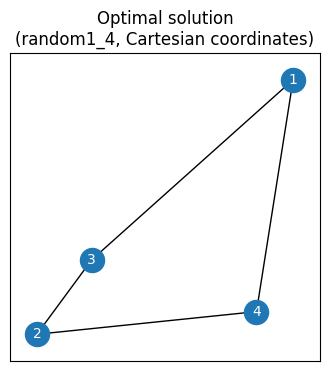

In [ ]:
if len(plot_cache) > MAX_VISUALIZATIONS:
	print('Aborting visualization: too many problems')
else:
	for problem_name, plot_data in plot_cache.items():
		plot_data.labels = loader.load_labels(
			os.path.join(TRAINING_PATH, 'solutions', problem_name + '.npy'))
		plot_data.plot(plot_data.labels, use_alpha=True)
		plt.title(f'Optimal solution\n{plot_data}')
		plt.rcParams["figure.figsize"] = (PYPLOT_W, PYPLOT_H)
		plt.show()